## Final Project Submission

Please fill out:
* Student name: Susanna Han
* Student pace: part time
* Scheduled project review date/time: 05/08/2020
* Instructor name: James Irving
* Blog post URL: https://medium.com/@susanna.jihae.han/project-mod-3-vesi-edf9a4387da4


# Introduction

All the imports and functions used in this project are imported below: 

In [1]:
!pip install -U fsds_100719
from fsds_100719.imports import *
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%conda update scikit-learn
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz
from IPython.display import Image  
from imblearn.over_sampling import SMOTE


fsds_1007219  v0.7.21 loaded.  Read the docs: https://fsds.readthedocs.io/en/latest/ 


Handle,Package,Description
dp,IPython.display,Display modules with helpful display and clearing commands.
fs,fsds_100719,Custom data science bootcamp student package
mpl,matplotlib,Matplotlib's base OOP module with formatting artists
plt,matplotlib.pyplot,Matplotlib's matlab-like plotting module
np,numpy,scientific computing with Python
pd,pandas,High performance data structures and tools
sns,seaborn,High-level data visualization library based on matplotlib


[i] Pandas .iplot() method activated.
Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


Using TensorFlow backend.


In [2]:
def plot_importance(tree_clf, top_n=10,figsize=(5,5)):
    df_importance = pd.Series(tree_clf.feature_importances_,index=X_train.columns)
    df_importance.sort_values(ascending=True).tail(top_n).plot(
        kind='barh',figsize=figsize)
    return df_importance

In [3]:
def evaluate_model(y_true, y_pred,X_true,clf):
    
    ## Classification Report / Scores 
    print(metrics.classification_report(y_true,y_pred))

    fig, ax = plt.subplots(figsize=(10,4),ncols=2)
    metrics.plot_confusion_matrix(clf,X_true,y_true,cmap="Greens",
                                  normalize='true',ax=ax[0])
    ax[0].set(title='Confusion Matrix')
    y_score = clf.predict_proba(X_true)[:,1]

    fpr,tpr,thresh = metrics.roc_curve(y_true,y_score)
    # print(f"ROC-area-under-the-curve= {}")
    roc_auc = round(metrics.auc(fpr,tpr),3)
    ax[1].plot(fpr,tpr,color='darkorange',label=f'ROC Curve (AUC={roc_auc})')
    ax[1].plot([0,1],[0,1],ls=':')
    ax[1].legend()
    ax[1].grid()
    ax[1].set(ylabel='True Positive Rate',xlabel='False Positive Rate',
          title='Receiver operating characteristic (ROC) Curve')
    plt.tight_layout()
    plt.show()
    try: 
        df_important = plot_importance(clf)
    except:
        df_important = None
        

In [4]:
import tzlocal
import datetime as dt
tz = tzlocal.get_localzone()
print(tz)
start = dt.datetime.now(tz)
print(start.strftime("%m/%d/%Y - %I:%M %p"))
print(dt.datetime.now(tz))

America/Los_Angeles
05/13/2020 - 09:18 AM
2020-05-13 09:18:01.624197-07:00


In [5]:
## a timer to record how long a process takes
class Timer():
    ## def init
    def __init__(self,format_="%m/%d/%y - %I:%M %p"):
        import tzlocal
        self.tz = tzlocal.get_localzone()
        self.fmt = format_
        self.created_at = self.get_time()# get time
        
    ## def get time method
    def get_time(self):
        import datetime as dt
        return dt.datetime.now(self.tz)

    ## def start
    def start(self):
        time = self.get_time()
        self.start = time
        print(f"[i] Timer started at{self.start.strftime(self.fmt)}")
        

    ## def stop
    def stop(self):
        time = self.get_time()
        self.end = time
        print(f"[i] Timer ended at {self.end.strftime(self.fmt)}")
        print(f"- Total time = {self.end-self.start}")
timer = Timer()
print(timer.created_at)

2020-05-13 09:18:01.634610-07:00


A classifier model used to predict whether a customer will ("soon") stop doing business with SyriaTel, a telecommunications company.

# Pre-Processing

First I pull in my dataset and explore the data I have to use to build my models.

In [6]:
df = pd.read_csv('telecom_churns.csv')
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

Through .info() we are able to gather the following information. 
- The dataset has 3333 rows and 21 columns. 
- The names of all the columns.
- There are no missing values in the data set.
- 1 bool (target) column.
- 16 float/int columns. 
- 4 object (categorical) columns. 

In [8]:
pd.DataFrame(df.isna().sum())
#There are no null values in the data set!

,0
state,0
account length,0
area code,0
phone number,0
international plan,0
voice mail plan,0
number vmail messages,0
total day minutes,0
total day calls,0
total day charge,0


After gathering the basic information of the dataset, pre-processing begins. Deciding which columns are important and converting the object data types to fit a model. 

In [9]:
df['phone number'].value_counts().sum()
# Every phone number in our data set is a different number.

3333

In [10]:
df = df.drop(columns = ['phone number','state'])
#drop phone number - does not provide any new information; drop state - area code shares similar information

In [11]:
d = {'yes': True, 'no': False}
df['international plan'] = df['international plan'].map(d)
# convert international plan from string to boolean.

In [12]:
d2 = {'yes': True, 'no': False}
df['voice mail plan'] = df['voice mail plan'].map(d2)
# convert voice mail plan from string to boolean.

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   account length          3333 non-null   int64  
 1   area code               3333 non-null   int64  
 2   international plan      3333 non-null   bool   
 3   voice mail plan         3333 non-null   bool   
 4   number vmail messages   3333 non-null   int64  
 5   total day minutes       3333 non-null   float64
 6   total day calls         3333 non-null   int64  
 7   total day charge        3333 non-null   float64
 8   total eve minutes       3333 non-null   float64
 9   total eve calls         3333 non-null   int64  
 10  total eve charge        3333 non-null   float64
 11  total night minutes     3333 non-null   float64
 12  total night calls       3333 non-null   int64  
 13  total night charge      3333 non-null   float64
 14  total intl minutes      3333 non-null   

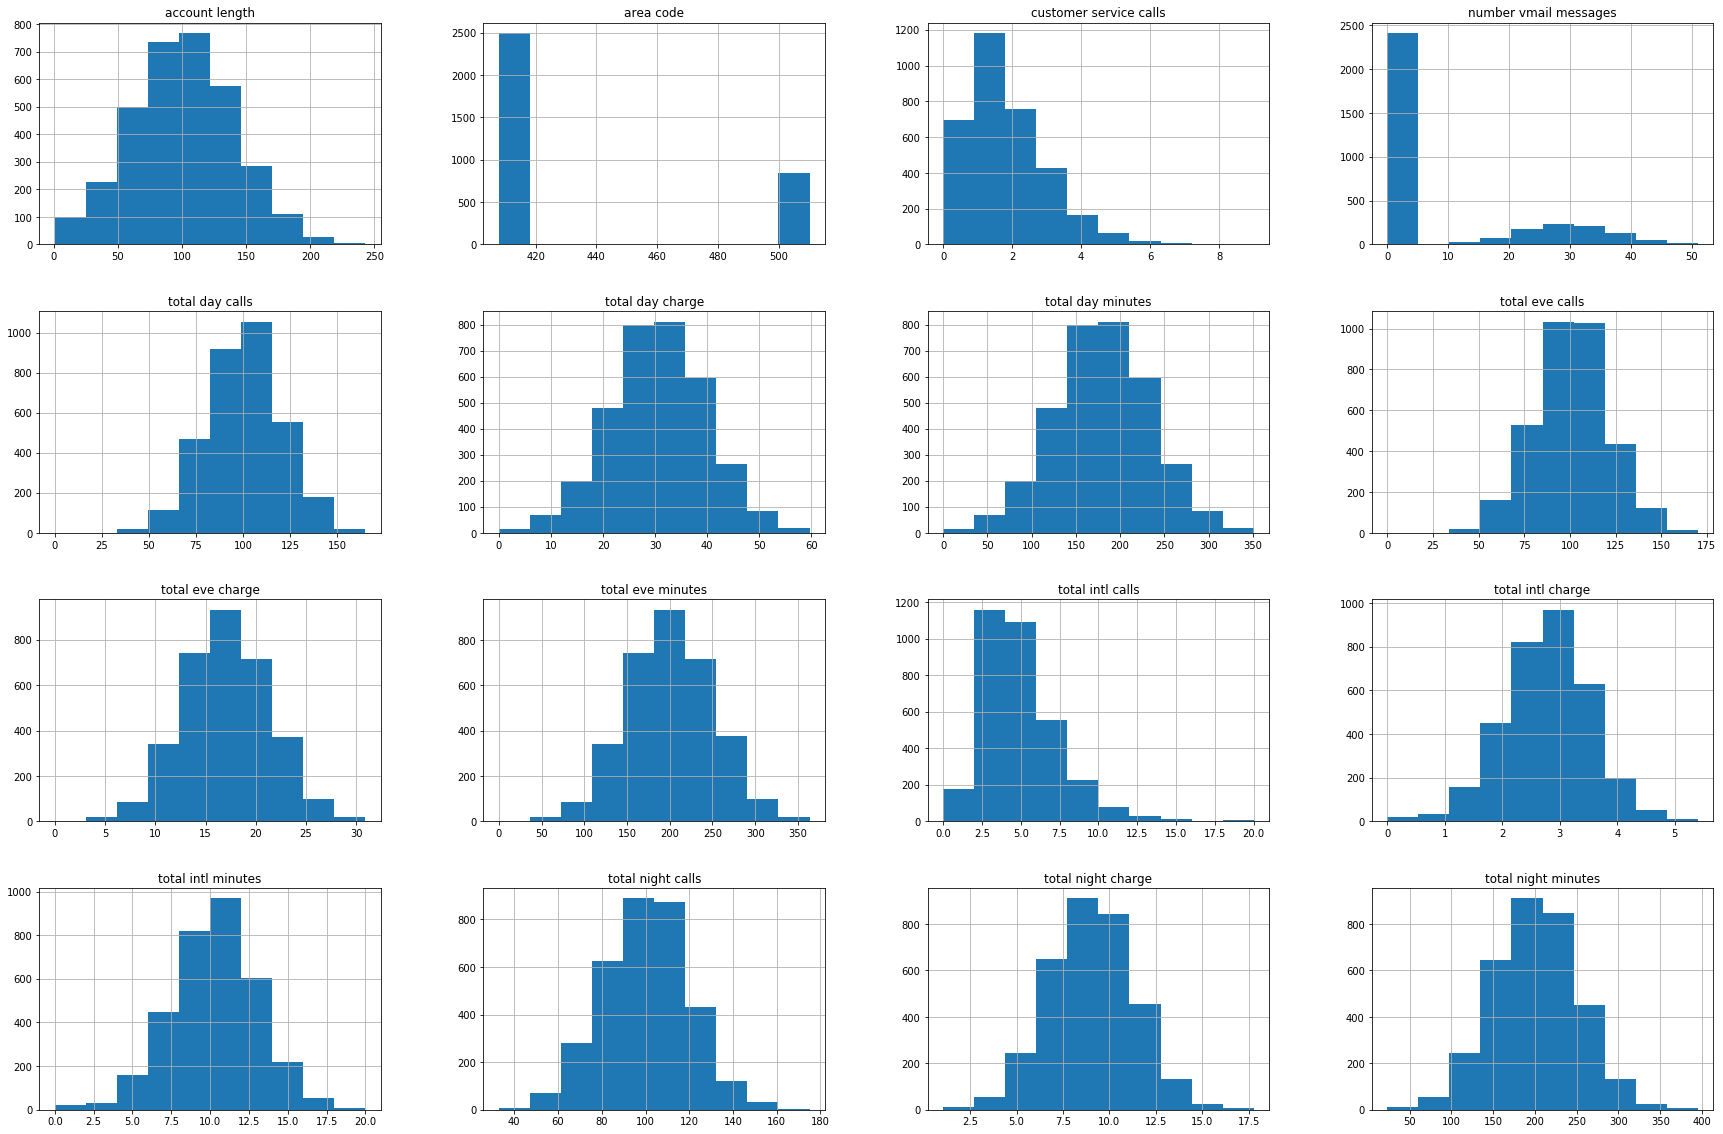

In [14]:
bool_drop = df.drop(columns = ['international plan','voice mail plan'])
feat = bool_drop.loc[:, 'account length':'customer service calls']
feat.hist(figsize=(30,20));

All of the variables in our dataset has an equal distribution shown in the histagrams above. The column, number vmail messages, shows that many people do not have a vmail setup. Therefore it is represented as a spike at zero in the graph. This is not a sign of abnormal distribution. Below is a heat map visualization in which shows a matrix of all variables and correlation with one another.

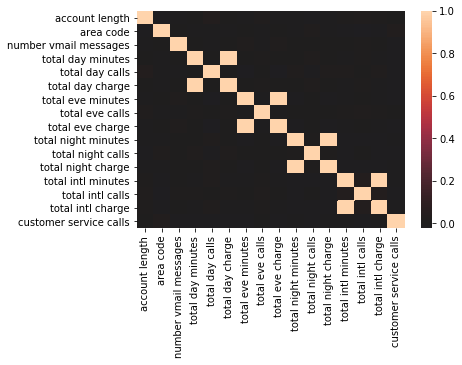

In [15]:
import seaborn as sns
sns.heatmap(feat.corr(), center=0);

In [16]:
df.info()
#double checking dataframe after pre-processing.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   account length          3333 non-null   int64  
 1   area code               3333 non-null   int64  
 2   international plan      3333 non-null   bool   
 3   voice mail plan         3333 non-null   bool   
 4   number vmail messages   3333 non-null   int64  
 5   total day minutes       3333 non-null   float64
 6   total day calls         3333 non-null   int64  
 7   total day charge        3333 non-null   float64
 8   total eve minutes       3333 non-null   float64
 9   total eve calls         3333 non-null   int64  
 10  total eve charge        3333 non-null   float64
 11  total night minutes     3333 non-null   float64
 12  total night calls       3333 non-null   int64  
 13  total night charge      3333 non-null   float64
 14  total intl minutes      3333 non-null   

# RF Model 1 (base_model)

The target is the variable that is being predicted and x is the remaining variables influencing the outcome. The train and test data are then split to fit the model(s). To ensure the model ahs equal amount of training. The train dataset is balanced to be 50% True and 50% False. 

In [17]:
y = df['churn']
X = df.drop('churn', axis=1)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 123)

In [19]:
y_train.value_counts(normalize=True)
#shows how inbalanced the dataset is.

False    0.85114
True     0.14886
Name: churn, dtype: float64

In [20]:
smote = SMOTE()
X_train, y_train = smote.fit_sample(X_train, y_train)
#balancing the train dataset to train the machine more equally.

In [21]:
pd.Series(y_train).value_counts(normalize=True)
#verifying the equalized dataset.

True     0.5
False    0.5
Name: churn, dtype: float64

Now that the dataset has been processed and equally distributed we fit the clean data through our first random forest algorithm model with no altered parameters.

In [22]:
timer = Timer()
timer.start()

base_tree = RandomForestClassifier()
base_tree.fit(X_train, y_train)
timer.stop()

[i] Timer started at05/13/20 - 09:18 AM
[i] Timer ended at 05/13/20 - 09:18 AM
- Total time = 0:00:00.912917


              precision    recall  f1-score   support

       False       0.98      0.95      0.96       723
        True       0.71      0.86      0.78       111

    accuracy                           0.94       834
   macro avg       0.85      0.90      0.87       834
weighted avg       0.94      0.94      0.94       834



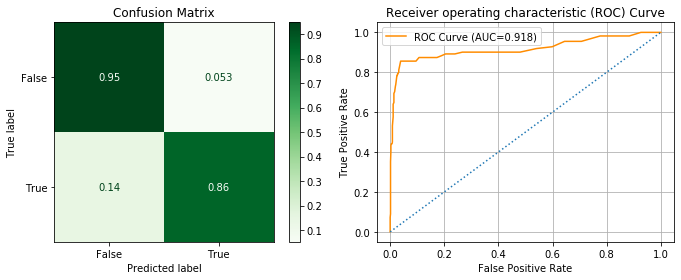

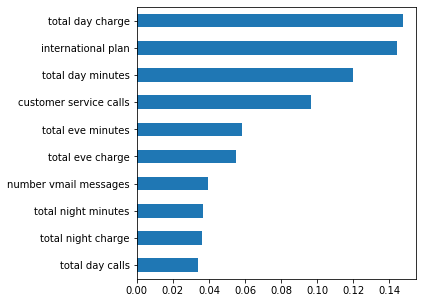

In [23]:
y_hat_test = base_tree.predict(X_test)
#predictions
evaluate_model(y_test, y_hat_test, X_test, base_tree)

In [24]:
df_import = pd.Series(base_tree.feature_importances_, index = X_train.columns,name='Importance')
display(df_import.sort_values(ascending=True).tail())

total eve minutes         0.058549
customer service calls    0.096660
total day minutes         0.120039
international plan        0.144473
total day charge          0.147320
Name: Importance, dtype: float64

In [25]:
display(base_tree.score(X_test, y_test))

0.935251798561151

We are able to see the top 5 important features shown above. The base model has an accuracy average of 94% and AUC score of 91%.

# RF- model 2 (best_tree)

Now that a base model was created, RandomizedSearchCV is used to compare different parameters of every combination listed below to tune the model.

In [26]:
rf_random = RandomForestClassifier()
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion': ['gini','entropy']}

In [30]:
# Random grid is used to search for best hyperparameters
# search across 100 different combinations, and use all available cores
timer = Timer()
timer.start()

rf_tree = RandomizedSearchCV(estimator = rf_random, 
                             param_distributions = random_grid, 
                             n_iter = 100,cv = 3, verbose=2, 
                             random_state=42, n_jobs = -1)
#Fitting 3 folds for each of 100 candidates, totalling 300 fits
# Fit the random search model
rf_tree.fit(X_train, y_train)
timer.stop()

[i] Timer started at05/13/20 - 09:18 AM
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 17.5min finished


[i] Timer ended at 05/13/20 - 09:36 AM
- Total time = 0:17:46.347319


In [31]:
display(rf_tree.best_params_)

{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': None,
 'criterion': 'entropy',
 'bootstrap': False}

In [32]:
best_tree = rf_tree.best_estimator_
#tree with best params
y_hat_test = best_tree.predict(X_test)
#predictions

              precision    recall  f1-score   support

       False       0.97      0.97      0.97       723
        True       0.80      0.84      0.82       111

    accuracy                           0.95       834
   macro avg       0.89      0.90      0.90       834
weighted avg       0.95      0.95      0.95       834



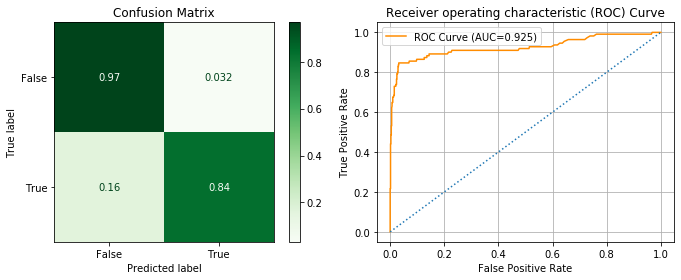

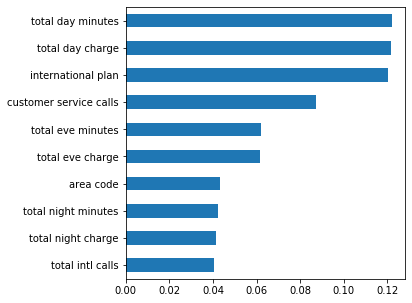

In [33]:
evaluate_model(y_test, y_hat_test, X_test, best_tree)

In [34]:
df_import = pd.Series(best_tree.feature_importances_, index = X_train.columns,name='Importance')
display(df_import.sort_values(ascending=True))

voice mail plan           0.016002
total eve calls           0.029694
total night calls         0.032381
total day calls           0.034180
total intl minutes        0.035228
total intl charge         0.035424
number vmail messages     0.037224
account length            0.037641
total intl calls          0.040353
total night charge        0.041428
total night minutes       0.042172
area code                 0.043196
total eve charge          0.061452
total eve minutes         0.062162
customer service calls    0.087481
international plan        0.120304
total day charge          0.121729
total day minutes         0.121948
Name: Importance, dtype: float64

In [35]:
display(best_tree.score(X_test, y_test))

0.9508393285371702

The same top 5 important features are shown above. The tuned model has an accuracy average of 95% and AUC score of 92%.

# Model Results

Multiple different parameters and combinations using RandomizedSearchCV resulted in little to none improvement. The top 5 important features in both the base model and tuned model are the same with minor differences. With the given parameters from the RandomizedSearchCV the tuned model was able to increase the accuracy score from 94% to 95%. As well as increasing the F1 score by 1.

The bar graph below shows that 14.5% of customers leave the telecom provider. To figure out in what direction the features have importance we compare the target variable with a independent variable.

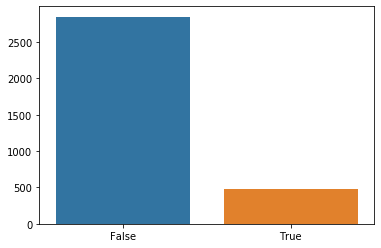

In [36]:
y = df["churn"].value_counts()
sns.barplot(y.index, y.values,);

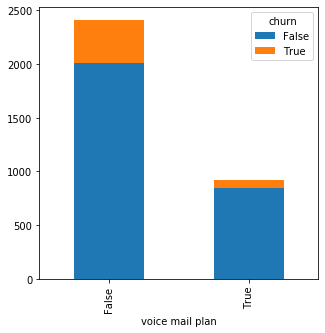

In [37]:
df.groupby(["voice mail plan", "churn"]).size().unstack().plot(kind='bar', stacked=True, figsize=(5,5)); 

There are more people with no voicemail than with voicemail. Also showing that there is a higher churn rate with those that have no voicemail. With this variable being the lowest feature importance it is compared with the international plan which is a top 3 important feature. The international plan shows us that those who do have an international plan have a higher churn rate than those who don't.

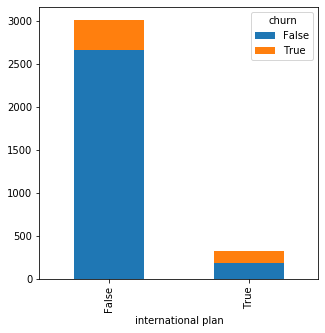

In [38]:
df.groupby(["international plan", "churn"]).size().unstack().plot(kind='bar', stacked=True, figsize=(5,5)); 

Therefore we are able to see that the highest important features show the correlation between the independent variables and the increased churn rate.

# Conclusion


The tuned model was able to provide a more accurate prediction. Therefore three insights/recommendations are listed below.

1. Customers who use more minutes during the day and get charged are more likely to stop doing business. Therefore looking into lowering the usage total during the day charge.

2. Customers that have a voice mail set up are more likely to continue business. Assist customers with setting up a voicemail may decrease the churn rate.

3. Customers who have an international plan are more likely to discontinue doing business.
